Using device: cpu
Loading model...


<ipython-input-22-b60e61b97e2e>:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Model loaded successfully

=== Starting Normalized Patch Analysis ===


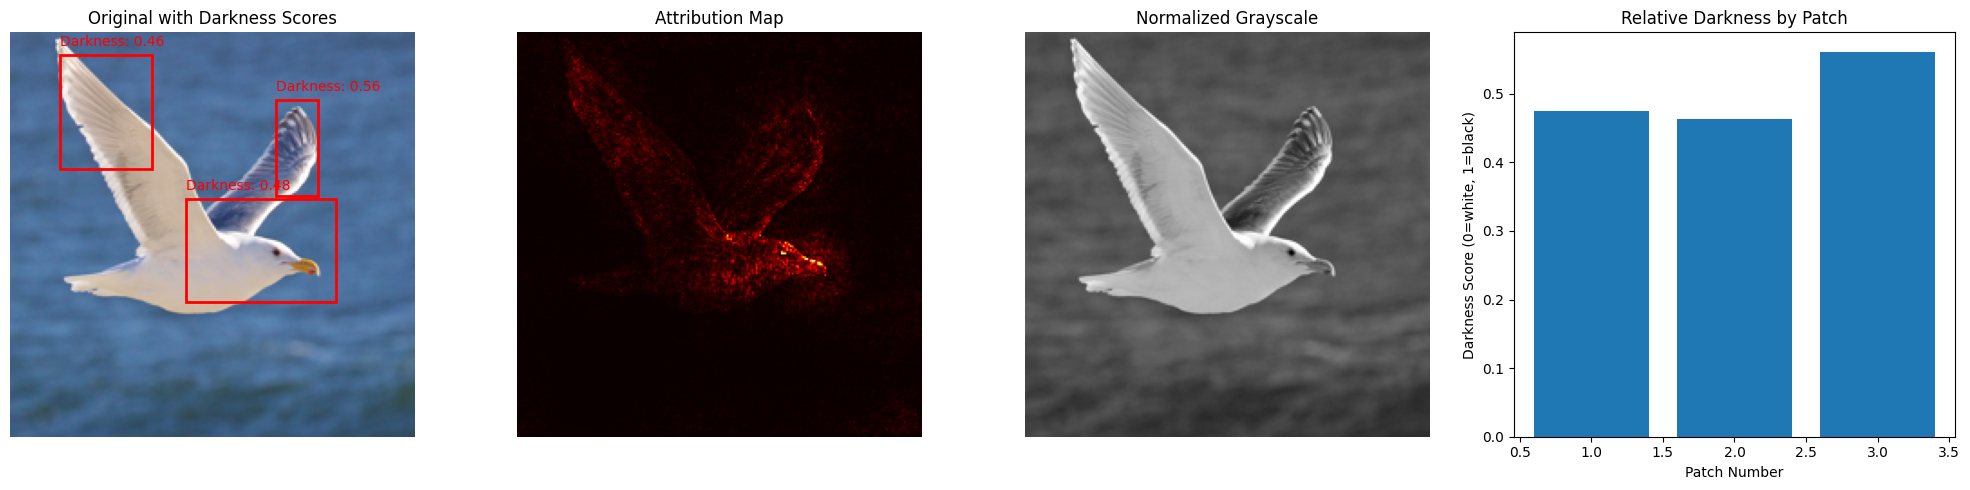


Patch Analysis Results:

Patch 1:
  Relative Darkness: 0.475
  Normalized Intensity: 0.525
  Location: (x: 97-180, y: 92-149)

Patch 2:
  Relative Darkness: 0.464
  Normalized Intensity: 0.536
  Location: (x: 27-78, y: 12-75)

Patch 3:
  Relative Darkness: 0.562
  Normalized Intensity: 0.438
  Location: (x: 147-170, y: 37-90)


In [22]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from captum.attr import DeepLift
import cv2
from scipy import ndimage

class VGG16Modified(nn.Module):
    def __init__(self):
        super(VGG16Modified, self).__init__()
        from torchvision.models import VGG16_Weights
        self.vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        num_ftrs = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.vgg(x)

def analyze_normalized_patch_tones(img_path, model, class_idx, n_patches=3):
    """
    Analyze patches with normalized intensity values
    """
    print("\n=== Starting Normalized Patch Analysis ===")

    # Step 1: Load and process image
    original_image = Image.open(img_path).convert('RGB')
    image_array = np.array(original_image.resize((224, 224)))

    # Step 2: Convert to grayscale and normalize
    grayscale = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    normalized_gray = (grayscale - grayscale.min()) / (grayscale.max() - grayscale.min())

    # Step 3: Prepare image for model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(original_image).unsqueeze(0)

    # Step 4: Generate attribution
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)
    deep_lift = DeepLift(model)
    attribution = deep_lift.attribute(image_tensor, target=class_idx)
    attribution = attribution.detach().cpu().numpy()

    # Step 5: Process attribution map
    abs_attr = np.sum(np.abs(attribution), axis=1).squeeze(0)
    normalized_attr = (abs_attr - abs_attr.min()) / (abs_attr.max() - abs_attr.min())

    # Step 6: Find connected components (patches)
    threshold = np.percentile(normalized_attr, 90)  # Top 10% of attribution values
    binary_mask = normalized_attr > threshold
    labeled_array, num_features = ndimage.label(binary_mask)

    # Step 7: Get patch properties
    patches = []
    for label in range(1, num_features + 1):
        patch_mask = labeled_array == label
        patch_size = np.sum(patch_mask)

        # Get patch coordinates
        coords = np.where(patch_mask)
        y_min, y_max = np.min(coords[0]), np.max(coords[0])
        x_min, x_max = np.min(coords[1]), np.max(coords[1])

        patches.append({
            'label': label,
            'mask': patch_mask,
            'bbox': (x_min, y_min, x_max, y_max),
            'size': patch_size
        })

    # Sort patches by size and get top N
    patches.sort(key=lambda x: x['size'], reverse=True)
    patches = patches[:n_patches]

    # Step 8: Calculate normalized intensity for each patch
    patch_intensities = []
    for patch in patches:
        x_min, y_min, x_max, y_max = patch['bbox']
        patch_region = normalized_gray[y_min:y_max+1, x_min:x_max+1]

        # Calculate normalized intensity metrics
        avg_intensity = np.mean(patch_region)
        relative_darkness = 1 - avg_intensity  # Convert to darkness score (0=white, 1=black)

        patch_intensities.append({
            'patch_id': len(patch_intensities) + 1,
            'relative_darkness': relative_darkness,
            'normalized_intensity': avg_intensity,
            'bbox': (x_min, y_min, x_max, y_max)
        })

    # Step 9: Visualization
    plt.figure(figsize=(20, 5))

    # Original image with patches
    plt.subplot(1, 4, 1)
    plt.imshow(image_array)
    for patch in patch_intensities:
        x_min, y_min, x_max, y_max = patch['bbox']
        plt.gca().add_patch(plt.Rectangle((x_min, y_min),
                                        x_max - x_min,
                                        y_max - y_min,
                                        fill=False,
                                        color='red',
                                        linewidth=2))
        plt.text(x_min, y_min-5, f"Darkness: {patch['relative_darkness']:.2f}",
                color='red', fontsize=10)
    plt.title("Original with Darkness Scores")
    plt.axis('off')

    # Attribution map
    plt.subplot(1, 4, 2)
    plt.imshow(normalized_attr, cmap='hot')
    plt.title("Attribution Map")
    plt.axis('off')

    # Normalized grayscale
    plt.subplot(1, 4, 3)
    plt.imshow(normalized_gray, cmap='gray')
    plt.title("Normalized Grayscale")
    plt.axis('off')

    # Darkness comparison
    plt.subplot(1, 4, 4)
    patch_nums = [p['patch_id'] for p in patch_intensities]
    darkness_scores = [p['relative_darkness'] for p in patch_intensities]
    plt.bar(patch_nums, darkness_scores)
    plt.title("Relative Darkness by Patch")
    plt.xlabel("Patch Number")
    plt.ylabel("Darkness Score (0=white, 1=black)")

    plt.tight_layout()
    plt.show()

    # Print analysis results
    print("\nPatch Analysis Results:")
    for patch in patch_intensities:
        print(f"\nPatch {patch['patch_id']}:")
        print(f"  Relative Darkness: {patch['relative_darkness']:.3f}")
        print(f"  Normalized Intensity: {patch['normalized_intensity']:.3f}")
        x_min, y_min, x_max, y_max = patch['bbox']
        print(f"  Location: (x: {x_min}-{x_max}, y: {y_min}-{y_max})")

    return patch_intensities

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Set paths
    checkpoint_path = '/content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241123/best_model_vgg_20241123.pth'
    img_path = '/content/1200 - 2024-10-22T213907.735.jpg'  # Update this path


    # Initialize and load model
    print("Loading model...")
    model = VGG16Modified()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model = model.to(device)
    model.eval()
    print("Model loaded successfully")

    # Analyze single image
    class_idx = 0  # Update based on your class
    patch_intensities = analyze_normalized_patch_tones(img_path, model, class_idx)

if __name__ == "__main__":
    main()

Using device: cpu
Loading model...


<ipython-input-21-716d77dcf130>:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Model loaded successfully

=== Starting Patch Tone Analysis ===

Step 1: Loading original image


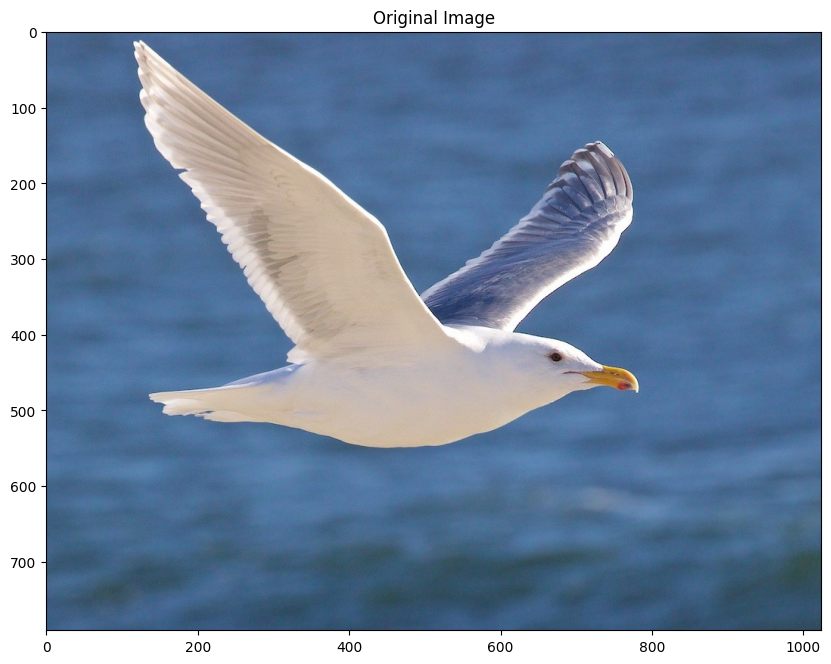

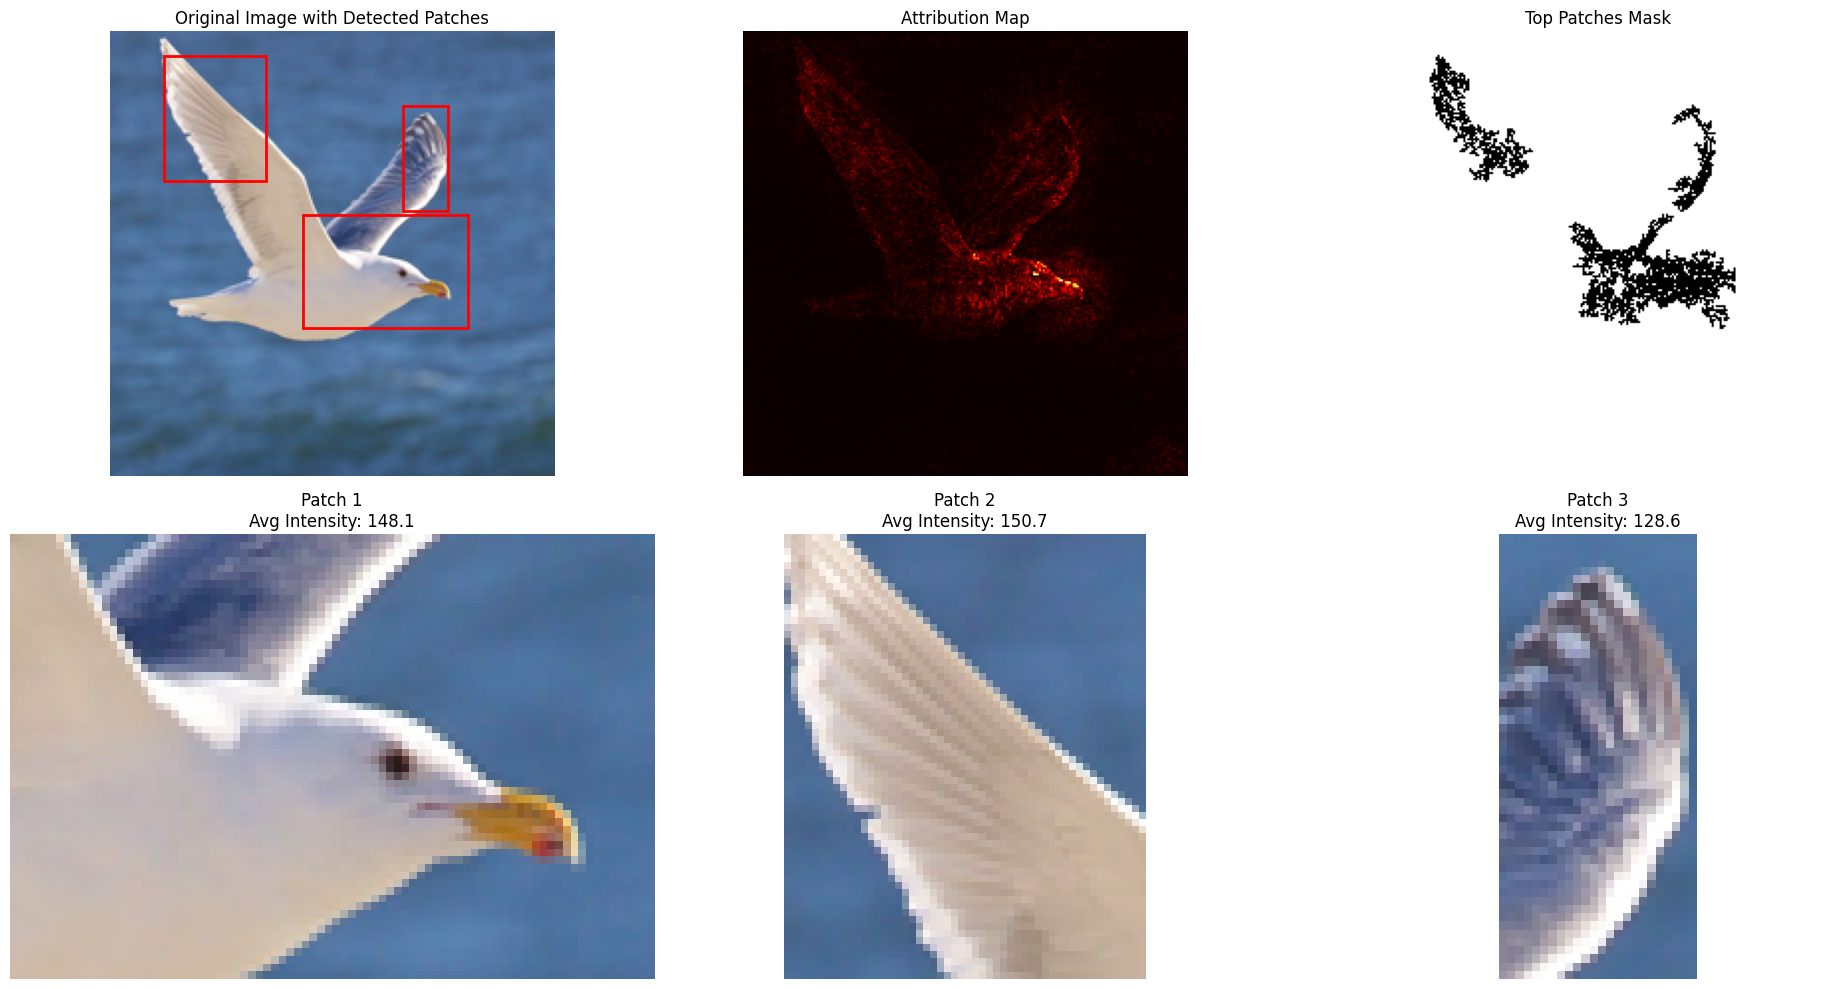


Patch Intensity Analysis:
Patch 1:
  Average Intensity: 148.1
  Size: 1919 pixels
  Location: (x: 97-180, y: 92-149)
Patch 2:
  Average Intensity: 150.7
  Size: 827 pixels
  Location: (x: 27-78, y: 12-75)
Patch 3:
  Average Intensity: 128.6
  Size: 364 pixels
  Location: (x: 147-170, y: 37-90)


In [21]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from captum.attr import DeepLift
import cv2
from scipy import ndimage

class VGG16Modified(nn.Module):
    def __init__(self):
        super(VGG16Modified, self).__init__()
        from torchvision.models import VGG16_Weights
        self.vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        num_ftrs = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.vgg(x)

def analyze_patch_tones(img_path, model, class_idx, n_patches=3):
    """
    Analyze the tones of the most important patches in the image,
    with focus on wingtip regions.
    """
    print("\n=== Starting Patch Tone Analysis ===")

    # Step 1: Load and display original image
    print("\nStep 1: Loading original image")
    original_image = Image.open(img_path).convert('RGB')
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.show()

    # Step 2: Prepare image for model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(original_image).unsqueeze(0)

    # Convert to numpy array for analysis
    image_array = np.array(original_image.resize((224, 224)))

    # Step 3: Generate attribution
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)
    deep_lift = DeepLift(model)
    attribution = deep_lift.attribute(image_tensor, target=class_idx)
    attribution = attribution.detach().cpu().numpy()

    # Step 4: Process attribution map
    abs_attr = np.sum(np.abs(attribution), axis=1).squeeze(0)
    normalized_attr = (abs_attr - abs_attr.min()) / (abs_attr.max() - abs_attr.min())

    # Step 5: Find connected components (patches)
    threshold = np.percentile(normalized_attr, 90)  # Top 10% of attribution values
    binary_mask = normalized_attr > threshold
    labeled_array, num_features = ndimage.label(binary_mask)

    # Step 6: Get patch properties
    patch_properties = []
    for label in range(1, num_features + 1):
        patch_mask = labeled_array == label
        patch_size = np.sum(patch_mask)

        # Get patch coordinates
        coords = np.where(patch_mask)
        y_min, y_max = np.min(coords[0]), np.max(coords[0])
        x_min, x_max = np.min(coords[1]), np.max(coords[1])

        # Calculate average intensity in the patch
        patch_region = image_array[y_min:y_max+1, x_min:x_max+1]
        grayscale_region = cv2.cvtColor(patch_region, cv2.COLOR_RGB2GRAY)
        avg_intensity = np.mean(grayscale_region)

        patch_properties.append({
            'label': label,
            'mask': patch_mask,
            'bbox': (x_min, y_min, x_max, y_max),
            'size': patch_size,
            'avg_intensity': avg_intensity
        })

    # Sort patches by size and get top N
    patch_properties.sort(key=lambda x: x['size'], reverse=True)
    top_patches = patch_properties[:n_patches]

    # Step 7: Visualize results
    plt.figure(figsize=(20, 10))

    # Original image with patches
    plt.subplot(2, 3, 1)
    plt.imshow(image_array)
    for patch in top_patches:
        x_min, y_min, x_max, y_max = patch['bbox']
        plt.gca().add_patch(plt.Rectangle((x_min, y_min),
                                        x_max - x_min,
                                        y_max - y_min,
                                        fill=False,
                                        color='red',
                                        linewidth=2))
    plt.title("Original Image with Detected Patches")
    plt.axis('off')

    # Attribution map
    plt.subplot(2, 3, 2)
    plt.imshow(normalized_attr, cmap='hot')
    plt.title("Attribution Map")
    plt.axis('off')

    # Patch masks
    plt.subplot(2, 3, 3)
    combined_mask = np.zeros_like(binary_mask)
    for patch in top_patches:
        combined_mask = combined_mask | patch['mask']
    plt.imshow(combined_mask, cmap='binary')
    plt.title("Top Patches Mask")
    plt.axis('off')

    # Individual patches and their intensities
    for idx, patch in enumerate(top_patches):
        plt.subplot(2, 3, 4 + idx)
        x_min, y_min, x_max, y_max = patch['bbox']
        patch_img = image_array[y_min:y_max+1, x_min:x_max+1].copy()
        plt.imshow(patch_img)
        plt.title(f"Patch {idx+1}\nAvg Intensity: {patch['avg_intensity']:.1f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print intensity analysis
    print("\nPatch Intensity Analysis:")
    for idx, patch in enumerate(top_patches):
        print(f"Patch {idx+1}:")
        print(f"  Average Intensity: {patch['avg_intensity']:.1f}")
        print(f"  Size: {patch['size']} pixels")
        print(f"  Location: (x: {patch['bbox'][0]}-{patch['bbox'][2]}, "
              f"y: {patch['bbox'][1]}-{patch['bbox'][3]})")

    return patch_properties

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Set paths
    checkpoint_path = '/content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241123/best_model_vgg_20241123.pth'
    img_path = '/content/1200 - 2024-10-22T213907.735.jpg'  # Update this path

    # Initialize and load model
    print("Loading model...")
    model = VGG16Modified()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model = model.to(device)
    model.eval()
    print("Model loaded successfully")

    # Analyze single image
    class_idx = 0  # Update based on your class
    patch_properties = analyze_patch_tones(img_path, model, class_idx)

if __name__ == "__main__":
    main()

In [ ]:

def analyze_patch_tones(img_path, model, class_idx, n_patches=3):
    """
    Analyze the tones of the most important patches in the image,
    with focus on wingtip regions.
    """
    print("\n=== Starting Patch Tone Analysis ===")

    # Step 1: Load and display original image
    print("\nStep 1: Loading original image")
    original_image = Image.open(img_path).convert('RGB')
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.show()

    # Step 2: Prepare image for model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(original_image).unsqueeze(0)

    # Convert to numpy array for analysis
    image_array = np.array(original_image.resize((224, 224)))

    # Step 3: Generate attribution
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)
    deep_lift = DeepLift(model)
    attribution = deep_lift.attribute(image_tensor, target=class_idx)
    attribution = attribution.detach().cpu().numpy()

    # Step 4: Process attribution map
    abs_attr = np.sum(np.abs(attribution), axis=1).squeeze(0)
    normalized_attr = (abs_attr - abs_attr.min()) / (abs_attr.max() - abs_attr.min())

    # Step 5: Find connected components (patches)
    threshold = np.percentile(normalized_attr, 90)  # Top 10% of attribution values
    binary_mask = normalized_attr > threshold
    labeled_array, num_features = ndimage.label(binary_mask)

    # Step 6: Get patch properties
    patch_properties = []
    for label in range(1, num_features + 1):
        patch_mask = labeled_array == label
        patch_size = np.sum(patch_mask)

        # Get patch coordinates
        coords = np.where(patch_mask)
        y_min, y_max = np.min(coords[0]), np.max(coords[0])
        x_min, x_max = np.min(coords[1]), np.max(coords[1])

        # Calculate average intensity in the patch
        patch_region = image_array[y_min:y_max+1, x_min:x_max+1]
        grayscale_region = cv2.cvtColor(patch_region, cv2.COLOR_RGB2GRAY)
        avg_intensity = np.mean(grayscale_region)

        patch_properties.append({
            'label': label,
            'mask': patch_mask,
            'bbox': (x_min, y_min, x_max, y_max),
            'size': patch_size,
            'avg_intensity': avg_intensity
        })

    # Sort patches by size and get top N
    patch_properties.sort(key=lambda x: x['size'], reverse=True)
    top_patches = patch_properties[:n_patches]

    # Step 7: Visualize results
    plt.figure(figsize=(20, 10))

    # Original image with patches
    plt.subplot(2, 3, 1)
    plt.imshow(image_array)
    for patch in top_patches:
        x_min, y_min, x_max, y_max = patch['bbox']
        plt.gca().add_patch(plt.Rectangle((x_min, y_min),
                                        x_max - x_min,
                                        y_max - y_min,
                                        fill=False,
                                        color='red',
                                        linewidth=2))
    plt.title("Original Image with Detected Patches")
    plt.axis('off')

    # Attribution map
    plt.subplot(2, 3, 2)
    plt.imshow(normalized_attr, cmap='hot')
    plt.title("Attribution Map")
    plt.axis('off')

    # Patch masks
    plt.subplot(2, 3, 3)
    combined_mask = np.zeros_like(binary_mask)
    for patch in top_patches:
        combined_mask = combined_mask | patch['mask']
    plt.imshow(combined_mask, cmap='binary')
    plt.title("Top Patches Mask")
    plt.axis('off')

    # Individual patches and their intensities
    for idx, patch in enumerate(top_patches):
        plt.subplot(2, 3, 4 + idx)
        x_min, y_min, x_max, y_max = patch['bbox']
        patch_img = image_array[y_min:y_max+1, x_min:x_max+1].copy()
        plt.imshow(patch_img)
        plt.title(f"Patch {idx+1}\nAvg Intensity: {patch['avg_intensity']:.1f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print intensity analysis
    print("\nPatch Intensity Analysis:")
    for idx, patch in enumerate(top_patches):
        print(f"Patch {idx+1}:")
        print(f"  Average Intensity: {patch['avg_intensity']:.1f}")
        print(f"  Size: {patch['size']} pixels")
        print(f"  Location: (x: {patch['bbox'][0]}-{patch['bbox'][2]}, "
              f"y: {patch['bbox'][1]}-{patch['bbox'][3]})")

    return patch_properties


Using device: cpu
Using device: cpu
Loading model...


<ipython-input-17-49bbc7f73dfc>:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Model loaded successfully

Processing image: /content/1200 - 2024-10-22T213907.735.jpg

=== Starting Debug Process ===

Step 1: Loading original image
Image path: /content/1200 - 2024-10-22T213907.735.jpg


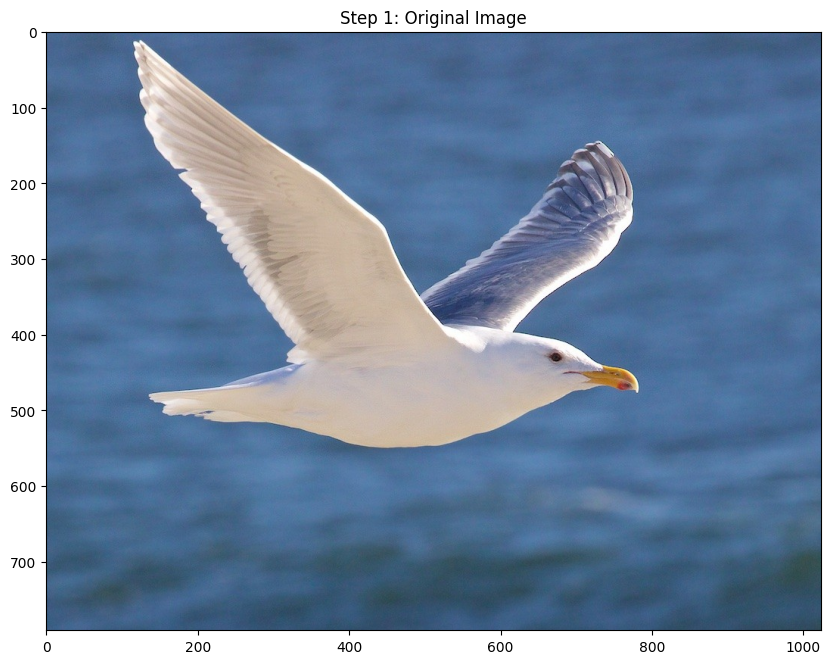


Step 2: Converting to numpy array
Image array shape: (224, 224, 3)


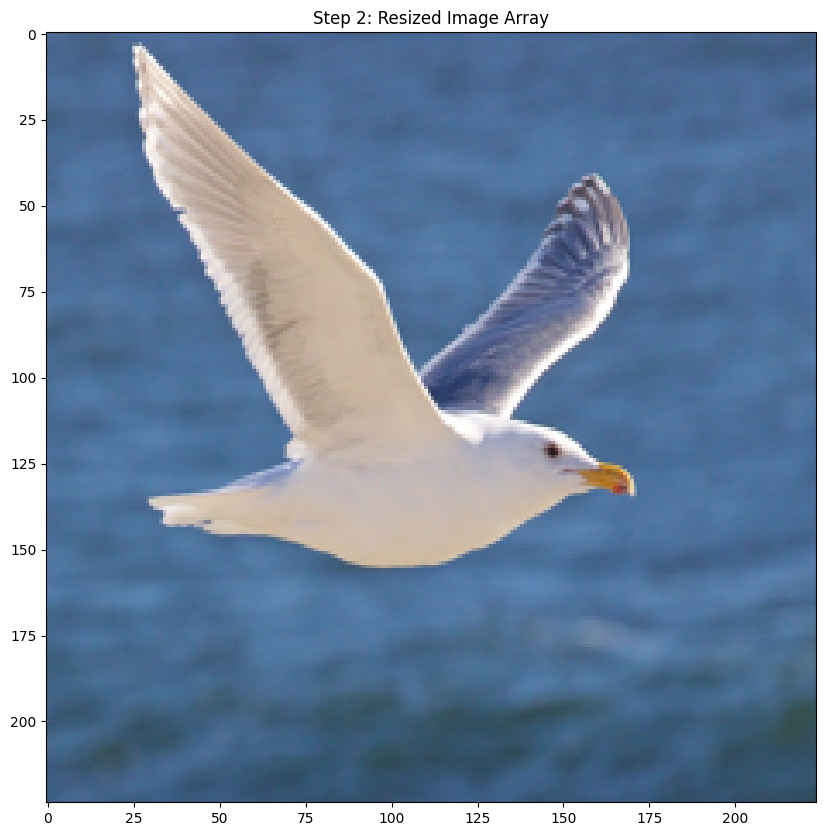


Step 3: Applying transforms
Image tensor shape: torch.Size([1, 3, 224, 224])

Step 4: Generating attribution
Attribution shape: (1, 3, 224, 224)

Step 5: Processing attribution map
Absolute attribution shape: (224, 224)
Normalized attribution shape: (224, 224)

Step 6: Creating binary mask
Important regions mask shape: (224, 224)

Step 8: Applying mask to original image


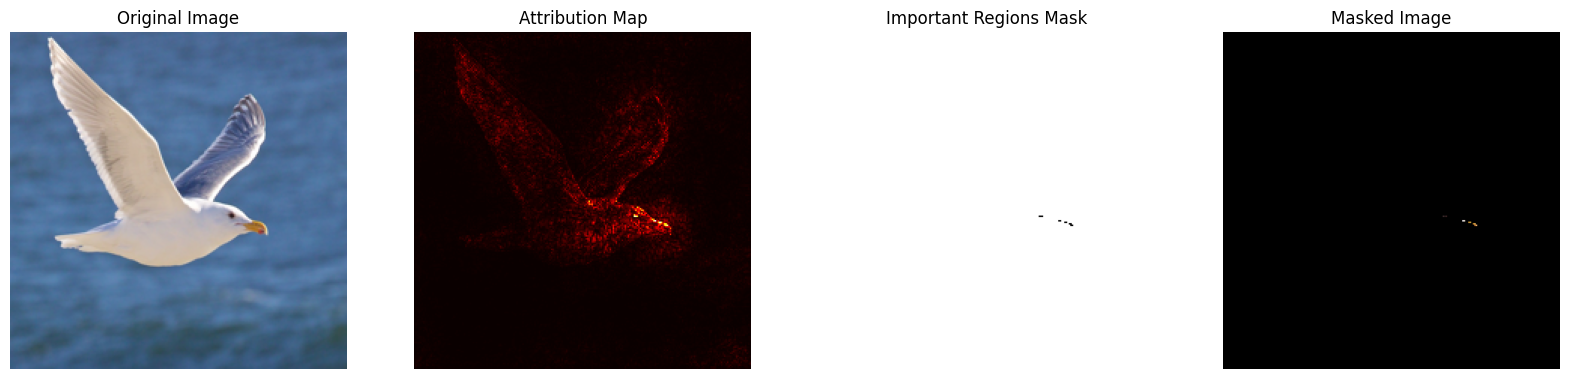


=== Debug Process Completed Successfully ===


In [17]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from captum.attr import DeepLift
import cv2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define class names
class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    """Preprocess image for model input"""
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor.to(device)

def load_model(checkpoint_path):
    """Load trained model"""
    model = VGG16Modified()
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.eval()
    return model


class VGG16Modified(nn.Module):
    def __init__(self):
        super(VGG16Modified, self).__init__()
        from torchvision.models import VGG16_Weights
        self.vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        num_ftrs = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.vgg(x)

def debug_image_processing(img_path, model, class_idx):
    print("\n=== Starting Debug Process ===")

    # Step 1: Load and display original image
    print("\nStep 1: Loading original image")
    print(f"Image path: {img_path}")
    original_image = Image.open(img_path).convert('RGB')
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image)
    plt.title("Step 1: Original Image")
    plt.show()

    # Step 2: Convert to numpy array and display
    print("\nStep 2: Converting to numpy array")
    image_array = np.array(original_image.resize((224, 224)))
    print(f"Image array shape: {image_array.shape}")
    plt.figure(figsize=(10, 10))
    plt.imshow(image_array)
    plt.title("Step 2: Resized Image Array")
    plt.show()

    # Step 3: Transform for model input
    print("\nStep 3: Applying transforms")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(original_image).unsqueeze(0)
    print(f"Image tensor shape: {image_tensor.shape}")

    # Move tensor to the same device as model
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)

    # Step 4: Generate attribution
    print("\nStep 4: Generating attribution")
    deep_lift = DeepLift(model)
    attribution = deep_lift.attribute(image_tensor, target=class_idx)
    attribution = attribution.detach().cpu().numpy()
    print(f"Attribution shape: {attribution.shape}")

    # Step 5: Process attribution map
    print("\nStep 5: Processing attribution map")
    abs_attr = np.sum(np.abs(attribution), axis=1)  # Sum across channels
    abs_attr = abs_attr.squeeze(0)  # Remove the batch dimension
    print(f"Absolute attribution shape: {abs_attr.shape}")
    normalized_attr = (abs_attr - abs_attr.min()) / (abs_attr.max() - abs_attr.min())
    print(f"Normalized attribution shape: {normalized_attr.shape}")

    # Step 6: Create binary mask
    print("\nStep 6: Creating binary mask")
    threshold = 0.7
    important_regions = normalized_attr > threshold
    print(f"Important regions mask shape: {important_regions.shape}")

    # Step 7: Display results
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(image_array)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(normalized_attr, cmap='hot')
    plt.title("Attribution Map")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(important_regions, cmap='binary')
    plt.title("Important Regions Mask")
    plt.axis('off')

    # Step 8: Apply mask to original image
    print("\nStep 8: Applying mask to original image")
    masked_image = image_array.copy()
    if len(masked_image.shape) == 3:  # RGB image
        important_regions_3d = np.expand_dims(important_regions, axis=-1)
        important_regions_3d = np.repeat(important_regions_3d, 3, axis=-1)
        masked_image = masked_image * important_regions_3d
    else:  # Grayscale image
        masked_image = masked_image * important_regions

    plt.subplot(1, 4, 4)
    plt.imshow(masked_image)
    plt.title("Masked Image")
    plt.axis('off')

    plt.show()

    return image_array, attribution, important_regions

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Set paths
    checkpoint_path = '/content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241123/best_model_vgg_20241123.pth'
    img_path = '/content/1200 - 2024-10-22T213907.735.jpg'  # Update this path
    class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']

    # Initialize and load model
    print("Loading model...")
    model = VGG16Modified()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model = model.to(device)
    model.eval()
    print("Model loaded successfully")

    # Get class index (assuming it's the first class)
    class_idx = 0

    try:
        print(f"\nProcessing image: {img_path}")
        image_array, attribution, regions = debug_image_processing(img_path, model, class_idx)
        print("\n=== Debug Process Completed Successfully ===")

    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        print(f"Error type: {type(e)}")
        import traceback
        print(f"Full traceback:\n{traceback.format_exc()}")

if __name__ == "__main__":
    main()

In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
